In [164]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [165]:
# mtx_names = ['cells_x_genes{}.mtx'.format(x) for x in ('','.2','.ambiguous')]
# data_names = ('spliced','unspliced','ambiguous')

In [166]:
# data_ind = 2

In [167]:
def plot_stat(X,Y,stat,ax1,modality='spliced',plot_offset=False):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,1,'k',alpha=0.3)
    xl = np.linspace(x.min(),x.max())
    ax1.plot(xl,xl,'--',color='crimson',linewidth=4)
    if plot_offset:
        offset = y.mean()/x.mean()
        print('Offset: {:.2f}'.format(np.log10(offset)))
        ax1.plot(xl,xl*offset,color='lightseagreen',linewidth=2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('single-cell {} {}'.format(stat,modality))
    ax1.set_ylabel('single-nucleus {} {}'.format(stat,modality))


# 10x

In [168]:
dataset_meta_sc = [f'brain_10x_30k_{i}' for i in range(1,5)]
dataset_meta_sn = [f'brain_nuc_10x_30k_{i}' for i in range(1,5)]
pair_ind = 3
dataset_meta= [dataset_meta_sc[pair_ind],dataset_meta_sn[pair_ind]]
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_meta] 
n_datasets = len(loom_filepaths)
dataset_names = dataset_meta 


In [169]:
loom_filepaths

['/home/ggorin/count_data/loom_10x_kb/brain_10x_30k_4.loom',
 '/home/ggorin/count_data/loom_10x_kb/brain_nuc_10x_30k_4.loom']

In [170]:
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [171]:

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]



/home/ggorin/count_data/loom_10x_kb/brain_10x_30k_4.loom
Dataset brain_10x_30k_4. 
	5178 barcodes in loom, 5150 pass filter.
/home/ggorin/count_data/loom_10x_kb/brain_nuc_10x_30k_4.loom
Dataset brain_nuc_10x_30k_4. 
	3285 barcodes in loom, 3256 pass filter.


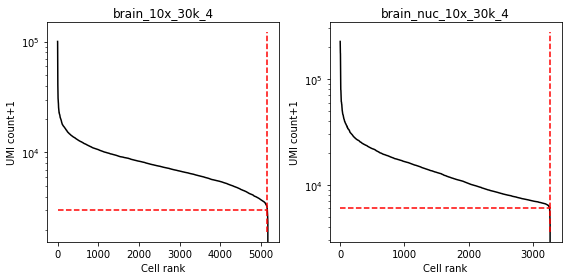

In [172]:
cf = []
thr_lb = [3e3, 6e3]
thr_ub = [1e5, 1e5]
S_arr = []
U_arr = []


fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = dataset_meta[k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k]) & ((S+U).sum(0)<thr_ub[k])
        ax1[k].set_title(dataset_meta[k])        
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter.')

        S_arr.append(S)
        U_arr.append(U)
        cf.append(cf_)
fig1.tight_layout()


/tmp/ipykernel_487915/3246091282.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


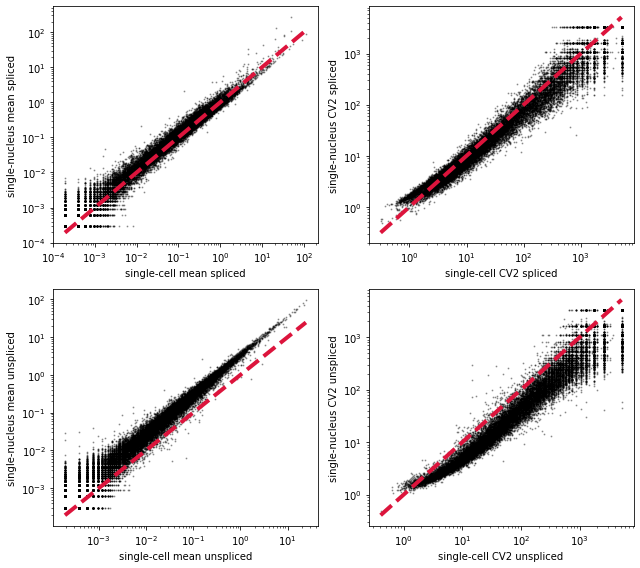

In [173]:
fig1,ax1 = plt.subplots(2,2,figsize=(9,8))

plot_stat(S_arr[0],S_arr[1],'mean',ax1[0][0],'spliced')
plot_stat(S_arr[0],S_arr[1],'CV2',ax1[0][1],'spliced')
plot_stat(U_arr[0],U_arr[1],'mean',ax1[1][0],'unspliced')
plot_stat(U_arr[0],U_arr[1],'CV2',ax1[1][1],'unspliced')
fig1.tight_layout()


In [41]:
# m = np.asarray(X_sc.mean(1)).squeeze()
# cv2 = np.asarray(cv2_fun(X_sc)).squeeze()

# Monod

In [174]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)


In [175]:
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1 already exists.
INFO:root:Dataset: brain_10x_30k_4
INFO:root:5150 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3895 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4 already exists.
INFO:root:Dataset: brain_nuc_10x_30k_4
INFO:root:3256 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5690 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4 already exists.
INFO:root:Total of 2000 genes selected.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/diagnostic_figures already exists.


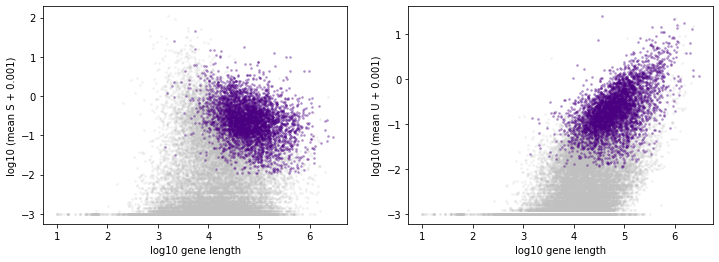

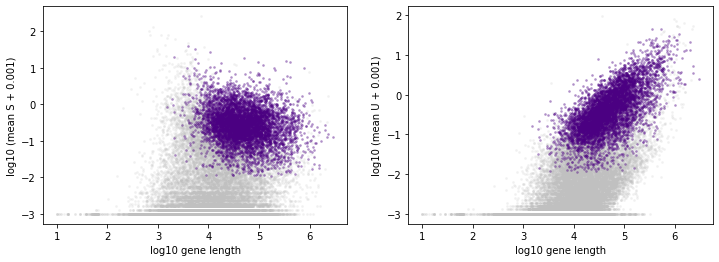

In [176]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='brain_nuc_4',batch_id=1,\
                                             n_genes=2000,exp_filter_threshold=None,cf=cf)


In [177]:
dir_string


'./fits/gg_230316_026_brain_nuc_4_1'

In [178]:
dataset_strings


['./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4',
 './fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4']

In [179]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
# samp_lb = [-8, -2.5]
# samp_ub = [-5, 0]
# gridsize = [10,11]
samp_lb = [-7.5, -2]
samp_ub = [-5.5, 0]
# gridsize = [5,6]
gridsize = [20,21]


gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1}


INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: brain_10x_30k_4
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230316_026_brain_nuc_4_1/genes.csv.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [2:14:48<00:00, 19.26s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 8090.3 seconds.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: brain_nuc_10x_30k_4
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230316_026_brain_nuc_4_1/genes.csv.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [3:50:10<00:00, 32.88s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 13812.5 seconds.


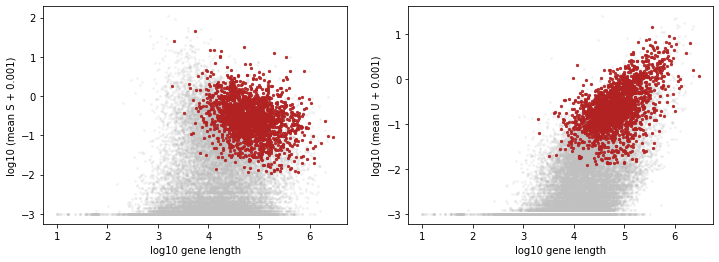

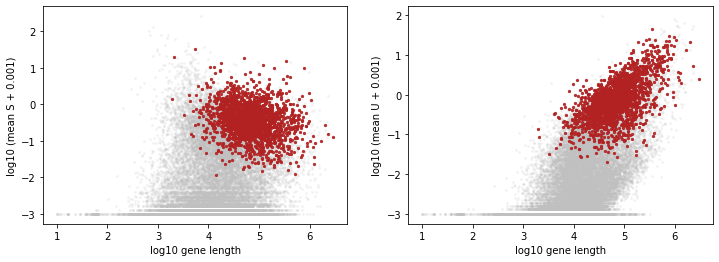

In [180]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(15,search_data)
    result_strings.append(full_result_string)


INFO:root:Grid scan results loaded from ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 24 genes out of 2000. Runtime: 9.2 seconds.
INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.24, -1.00.
INFO:root:Chi-square computatio

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 97 genes 

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230316_026_brain_nuc_4_1/analysis_figures already exists.


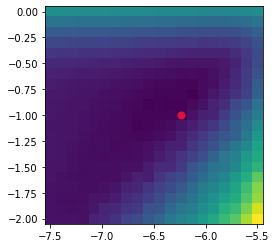

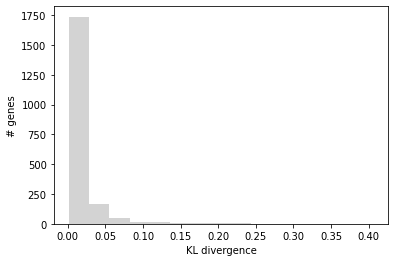

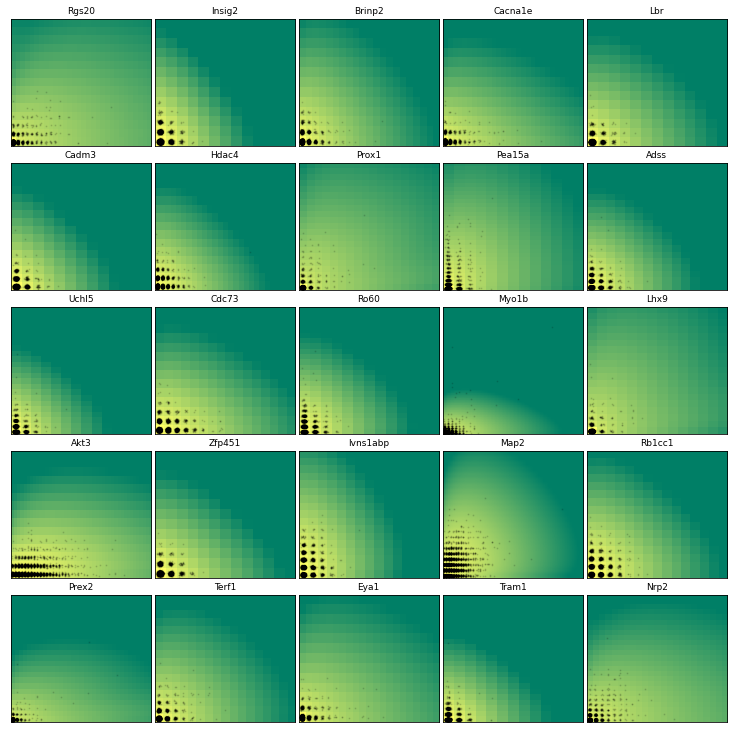

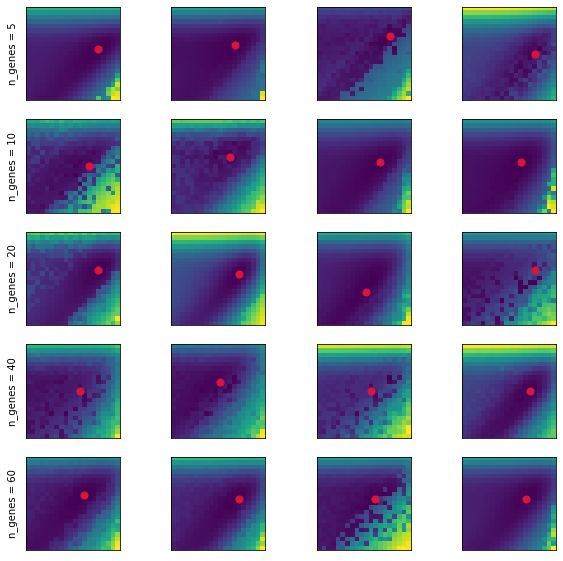

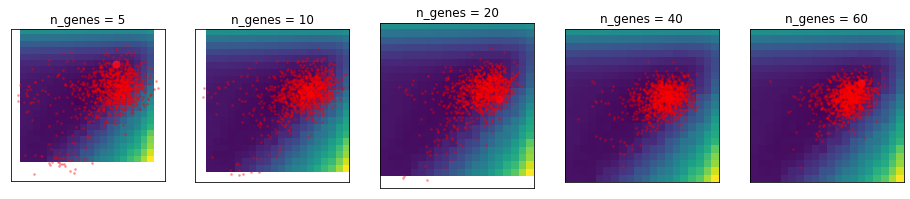

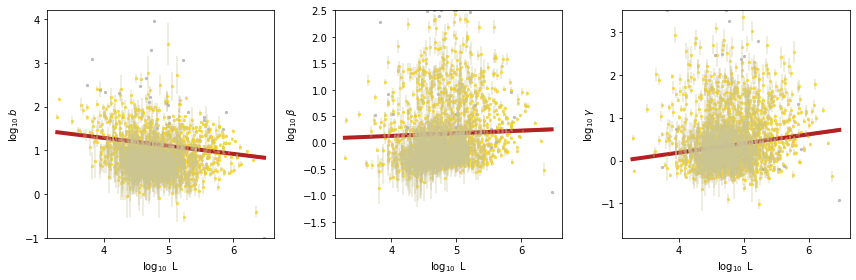

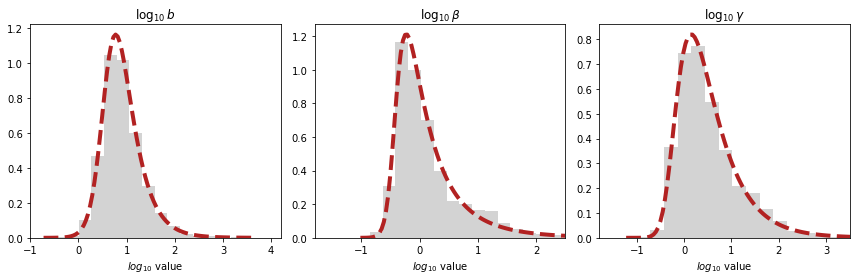

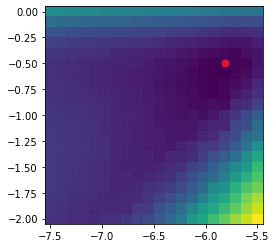

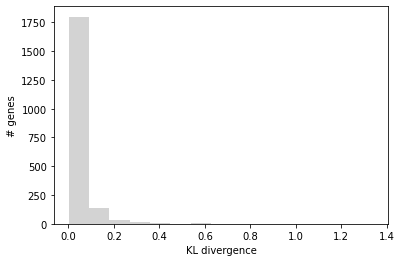

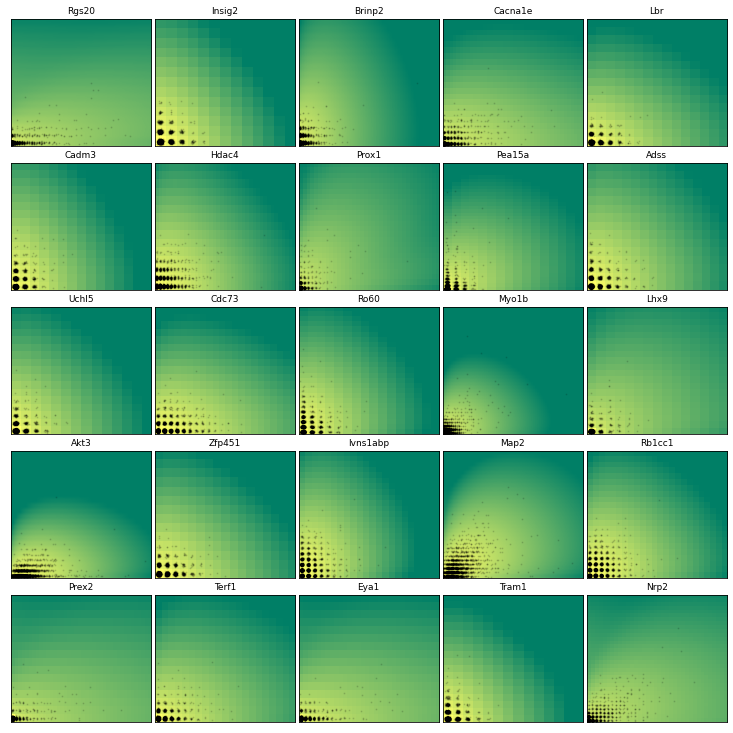

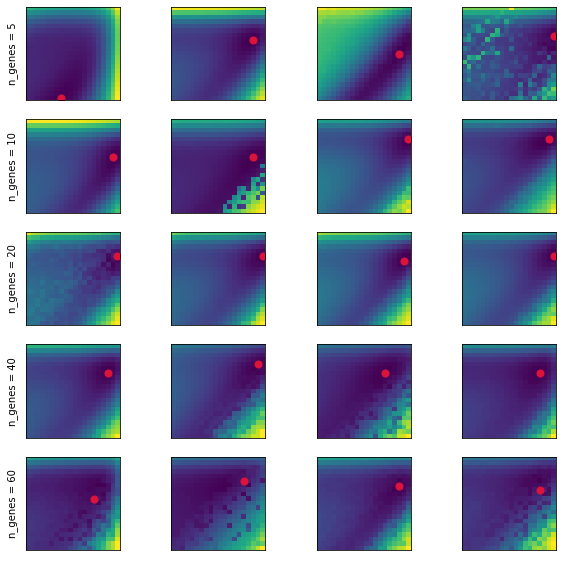

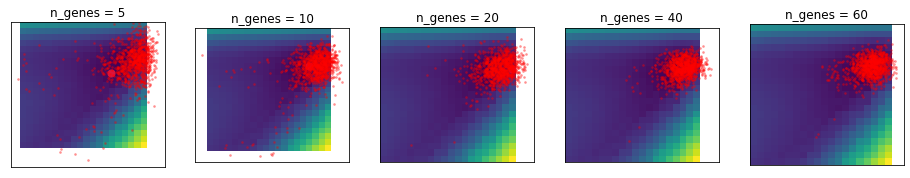

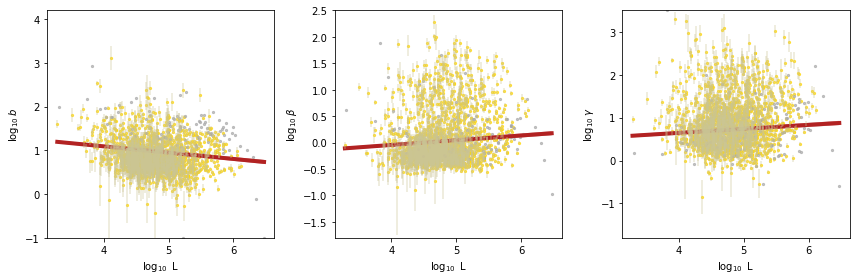

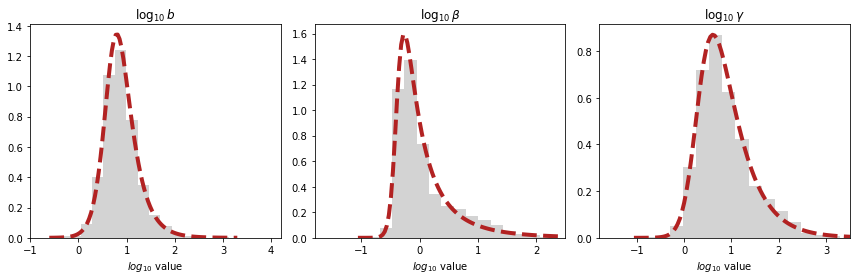

In [181]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=15)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [182]:
dir_string

'./fits/gg_230316_026_brain_nuc_4_1'

In [183]:
dataset_strings

['./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4',
 './fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4']

In [184]:
result_strings

['./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_20x21/grid_scan_results.res']

In [61]:
sr_arr[0].samp_optimum_ind

61

In [127]:
dir_string = './fits/gg_230316_026_brain_nuc_4_1'
dataset_strings = ['./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4',
 './fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4']
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_10x11/grid_scan_results_upd.res' for x in dataset_names]

# dir_string = './fits/gg_221209_025_brain_nuc_1' trash
# dataset_names = ['brain_5k_v3','brain_nuc_5k_v3']
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

# dir_string = './fits/gg_221210_025_allen_nuc_1'
# dataset_names = ['allen_B08_Glutamatergic','allen_A02_Glutamatergic']
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

# dir_string = './fits/gg_221210_025_allen_nuc_1'
# dataset_names = ['allen_B08_GABAergic','allen_A02_GABAergic']
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]


In [128]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]


INFO:root:Grid scan results loaded from ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/Bursty_Poisson_10x11/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/Bursty_Poisson_10x11/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_230316_026_brain_nuc_4_1/brain_10x_30k_4/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230316_026_brain_nuc_4_1/brain_nuc_10x_30k_4/raw.sd.


In [146]:
lay = 0
cc_sc = np.corrcoef(sd_arr[0].layers[lay])
cc_sn = np.corrcoef(sd_arr[1].layers[lay])
cc_sc = cc_sc[np.triu_indices(cc_sc.shape[0],1)].flatten()
cc_sn = cc_sn[np.triu_indices(cc_sn.shape[0],1)].flatten()

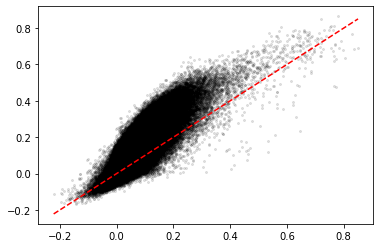

In [147]:
plt.scatter(cc_sc,cc_sn,4,'k',alpha=0.1)
xl = [min(cc_sc),max(cc_sc)]
plt.plot(xl,xl,'r--')

In [138]:
cc_sc.shape

(1000, 1000)

In [161]:

for j in range(3):
    x = sr_arr[0].phys_optimum[gf,j]
    y = sr_arr[1].phys_optimum[gf,j]
    print(scipy.stats.ttest_ind(x,y,equal_var=False))

Ttest_indResult(statistic=-5.652002167892929, pvalue=1.8326463078466426e-08)
Ttest_indResult(statistic=2.1548237141906905, pvalue=0.03130441851660372)
Ttest_indResult(statistic=-17.116984328141637, pvalue=4.01311131887026e-61)


74

In [153]:
# ((sr_arr[1].param_estimates[:,~sr_arr[0].rejected_genes,:] - sr_arr[0].phys_optimum[~sr_arr[0].rejected_genes])**2).shape

(110, 989, 3)

(-6.333333333333334, -1.0)
(-6.0, -0.5)
0.9005768145133543
0.9706349063689661
0.9440853448339364


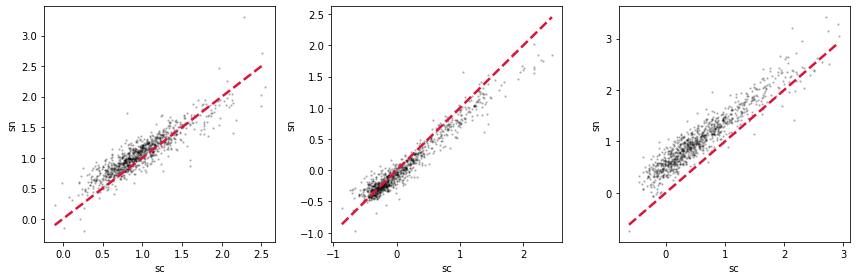

In [163]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
gf = (~sr_arr[1].rejected_genes)&(~sr_arr[0].rejected_genes)
arbitrary_v3_params = np.asarray(sr_arr[0].samp_optimum)+0.2
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
arbitrary_v3_ind = np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[0].rejected_genes,:] - sr_arr[0].phys_optimum[~sr_arr[0].rejected_genes])**2)[:,:,:2].sum((1,2)))
sr_arr[1].set_sampling_optimum(arbitrary_v3_ind)
print(sr_arr[0].samp_optimum)
print(sr_arr[1].samp_optimum)
for j in range(3):
    x = sr_arr[0].phys_optimum[gf,j]
    y = sr_arr[1].phys_optimum[gf,j]
    print(np.corrcoef(x,y)[0,1])
    ax1[j].scatter(x,y,2,'k',alpha=0.2)
    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j].set_xlabel('sc')
    ax1[j].set_ylabel('sn')
fig1.tight_layout()

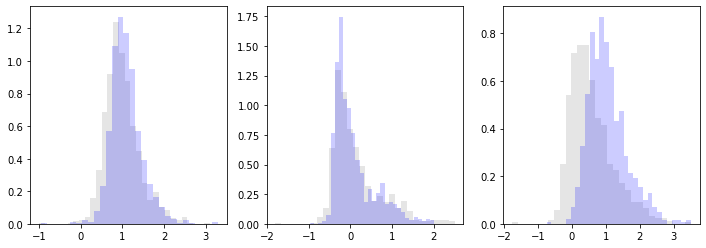

In [162]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
colors = ['gray']*1+['b']*1
for j in range(3):
    for k,sr in enumerate(sr_arr):
        ax1[j].hist(sr.phys_optimum[:,j],30,alpha=0.2,color=colors[k],density=True)
